# Interpolate Satellite SLA at CTD locations

In [10]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyresample import geometry, kd_tree
import os

Open satellite data

In [26]:
sla_1993 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_1993.nc')
sla_2024 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_2024.nc')

In [28]:
sla_1993_day = sla_1993.sla.sel(time='1993-06-15') # midpoint in CTD profile sampling period

In [30]:
sla_2024_day = sla_2024.sla.sel(time='2024-06-15') # midpoint in CTD profile sampling period

In [32]:
sla_diff = ssh_2024_day - ssh_1993_day

Open CTD data

In [43]:
# open ctd data from WOCE line AR7W from 1993
ar7w_1993_ds = xr.open_dataset('/Users/mzahn/data/Labrador_AR7W/cchdo_AR07W/3_18HU93019_1_ctd.nc')

In [45]:
# open all WOD ctd data
wod_ctd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.CTD/ocldb1769457252.646961.CTD.nc')

In [47]:
# select only profiles from 2024
wod_ctd_2024 = wod_ctd_ds.swap_dims({'casts':'time'}).sel(time='2024')

In [49]:
wod_ctd_2024

<xarray.Dataset> Size: 940B
Dimensions:  (time: 47)
Coordinates:
  * time     (time) datetime64[ns] 376B 2024-05-31T00:56:15.000000512 ... 202...
Data variables:
    lat      (time) float32 188B dask.array<chunksize=(47,), meta=np.ndarray>
    lon      (time) float32 188B dask.array<chunksize=(47,), meta=np.ndarray>
    cast     (time) int32 188B dask.array<chunksize=(47,), meta=np.ndarray>

## Plot difference in SLA

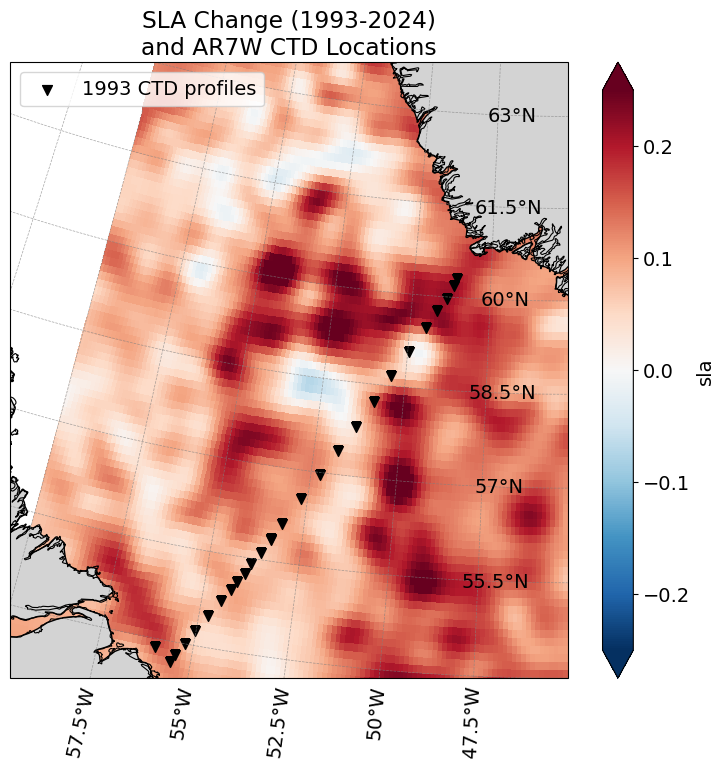

In [56]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-60, -45, 54, 63], crs=ccrs.PlateCarree())

# plot ssh
sla_diff.plot(vmin=-0.25,vmax=0.25,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ax.scatter(
    ar7w_1993_ds.longitude.values,
    ar7w_1993_ds.latitude.values,
    s=50,
    color="k", marker='v',
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles')

# Title and legend
plt.title("SLA Change (1993-2024)\nand AR7W CTD Locations")
plt.legend(loc='upper left')
plt.show()

## Collocate CTD profiles with SLA measurement

Interpolate to closest CTD location

In [132]:
sla_interp_list = []
# loop through all CTD profiles and interpolate to exact coordinate
for i in range(len(ar7w_1993_ds.time)):
    prof = ar7w_1993_ds.isel(N_PROF=i)
    date = np.datetime64(prof.time.values, 'D').astype(str)

    sla_val = (sla_1993.sla.sel(time=date).interp(latitude=prof.latitude, 
                                                  longitude=prof.longitude).values)

    sla_interp_list.append(sla_val)

# make final dataarray with all interpolated sla vals
sla_ctd = xr.DataArray(
    np.array(sla_interp_list),
    dims="N_PROF",
    coords={
        "time": ("N_PROF", ar7w_1993_ds.time.values),
        "latitude": ("N_PROF", ar7w_1993_ds.latitude.values),
        "longitude": ("N_PROF", ar7w_1993_ds.longitude.values),
    },
    name="sla_interp",
    attrs={"units": "m"})

In [134]:
sla_ctd

<xarray.DataArray 'sla_interp' (N_PROF: 27)> Size: 216B
array([-0.10761613, -0.09536745, -0.09048321, -0.0724833 , -0.05120282,
       -0.02938624, -0.00505671, -0.00214952, -0.00781808, -0.0095223 ,
       -0.00535394, -0.00511992, -0.01544647, -0.01475987, -0.01892697,
        0.00839933,  0.00329823, -0.01298954, -0.01166818, -0.01626306,
       -0.00181443,  0.01306968, -0.05997011, -0.07842005, -0.07453305,
       -0.09503444, -0.09638491])
Coordinates:
    time       (N_PROF) datetime64[ns] 216B 1993-06-19T13:08:00 ... 1993-06-2...
    latitude   (N_PROF) float64 216B 53.86 53.68 53.79 ... 59.97 60.18 60.3
    longitude  (N_PROF) float64 216B -55.99 -55.54 -55.44 ... -48.68 -48.62
Dimensions without coordinates: N_PROF
Attributes:
    units:    m

### Sanity check map

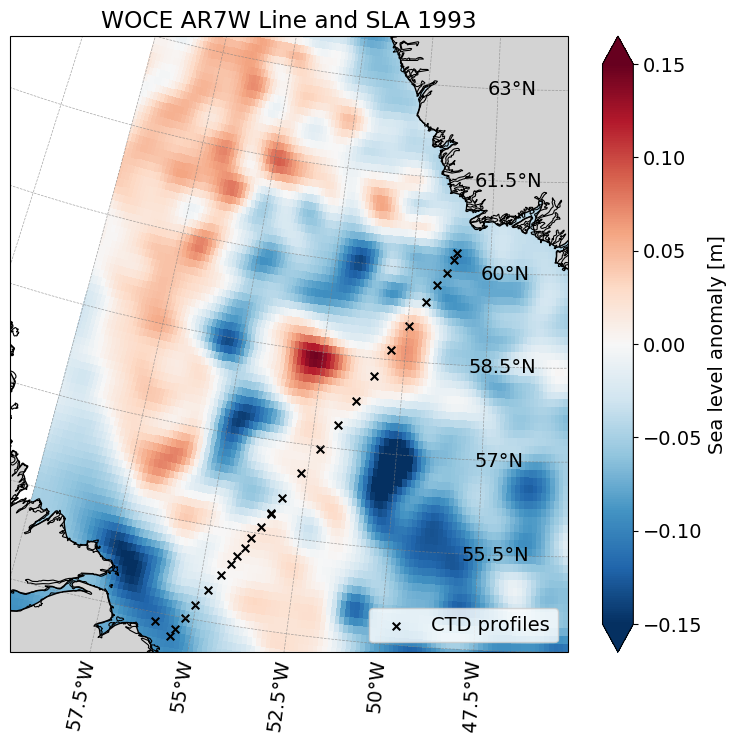

In [118]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-60, -45, 54, 63], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993_day.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ax.scatter(
    sla_ctd.longitude.values,
    sla_ctd.latitude.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(), label='CTD profiles')

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
plt.legend(loc='lower right')
plt.show()

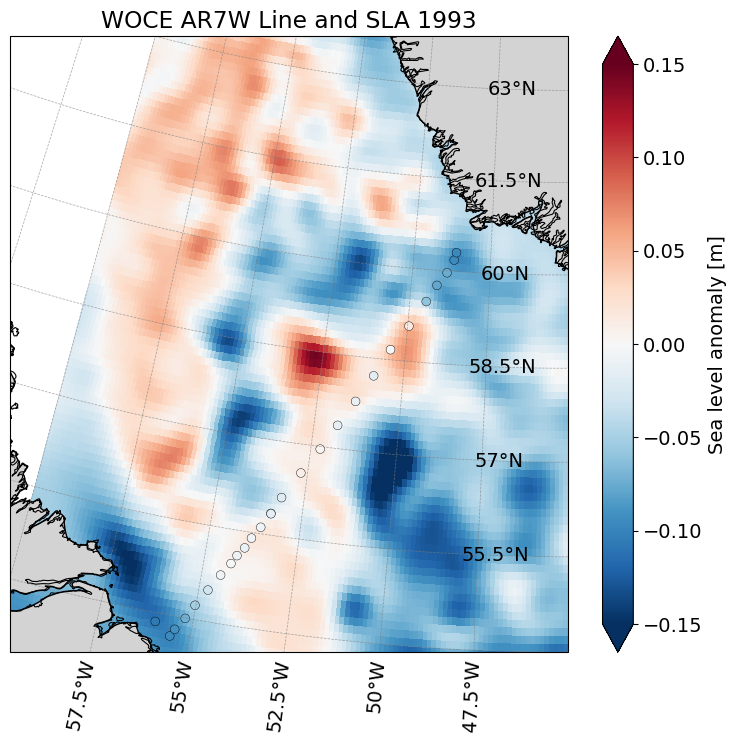

In [136]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-60, -45, 54, 63], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993_day.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
sc = ax.scatter(sla_ctd.longitude.values,sla_ctd.latitude.values,
    c=sla_ctd.values,s=40,
    cmap='RdBu_r',vmin=-0.15,vmax=0.15,
    marker='o',edgecolors='k',linewidths=0.3,
    transform=ccrs.PlateCarree())

# cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
# cbar.set_label('SLA (m)')

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
# plt.legend()
plt.show()

In [171]:
sla_ctd.isel(N_PROF=-6)

<xarray.DataArray 'sla_interp' ()> Size: 8B
array(0.01306968)
Coordinates:
    time       datetime64[ns] 8B 1993-06-22T23:48:00
    latitude   float64 8B 59.07
    longitude  float64 8B -49.96
Attributes:
    units:    m

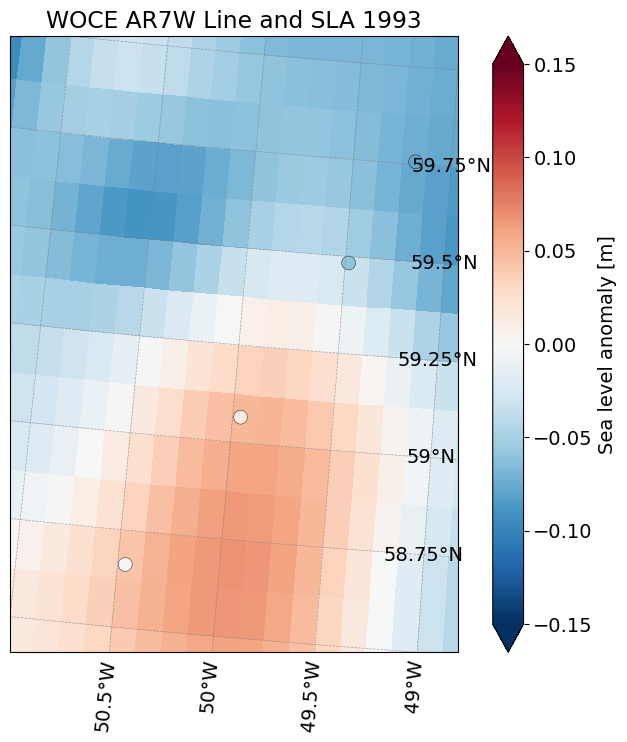

In [161]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-51, -49, 58.5, 60], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993_day.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
sc = ax.scatter(sla_ctd.longitude.values,sla_ctd.latitude.values,
    c=sla_ctd.values,s=100,
    cmap='RdBu_r',vmin=-0.15,vmax=0.15,
    marker='o',edgecolors='k',linewidths=0.3,
    transform=ccrs.PlateCarree())

# cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
# cbar.set_label('SLA (m)')

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
# plt.legend()
plt.show()

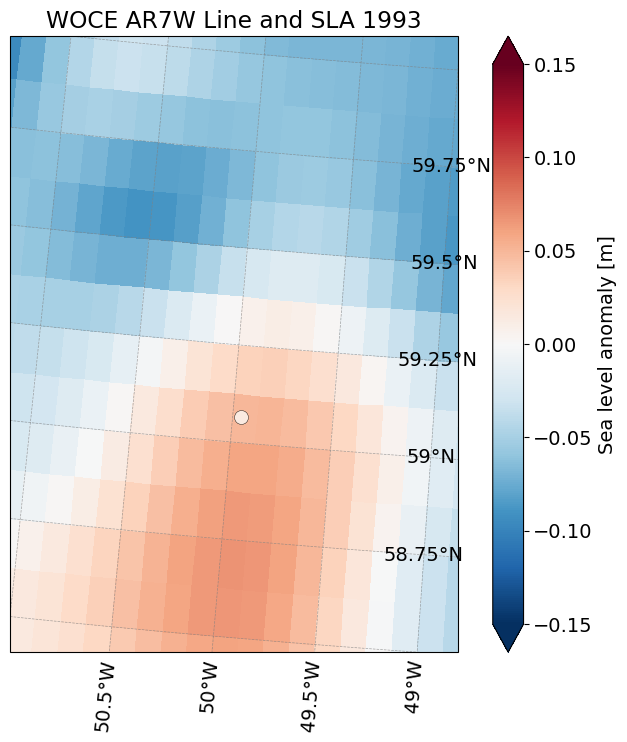

In [173]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-51, -49, 58.5, 60], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993_day.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
sc = ax.scatter(sla_ctd.isel(N_PROF=-6).longitude.values,sla_ctd.isel(N_PROF=-6).latitude.values,
    c=sla_ctd.isel(N_PROF=-6).values,s=100,
    cmap='RdBu_r',vmin=-0.15,vmax=0.15,
    marker='o',edgecolors='k',linewidths=0.3,
    transform=ccrs.PlateCarree())

# cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
# cbar.set_label('SLA (m)')

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
# plt.legend()
plt.show()

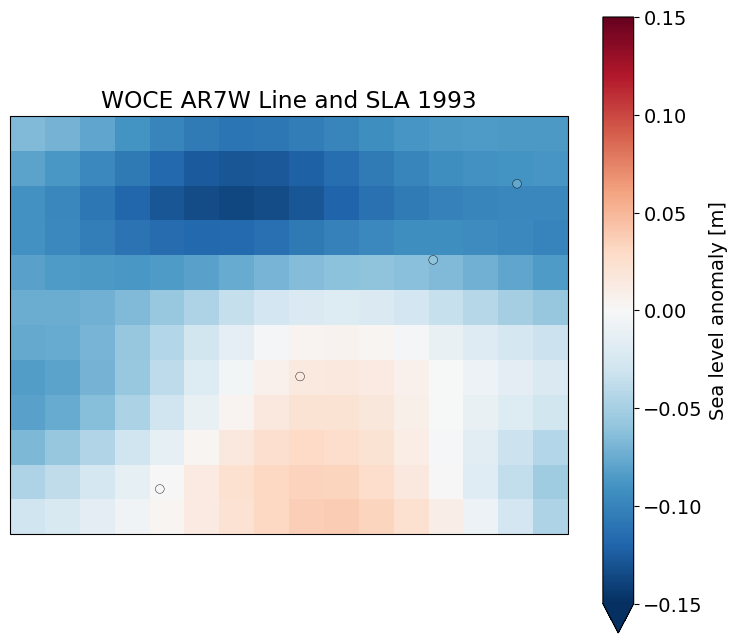

In [183]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
# gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.left_labels = True
# gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-51, -49, 58.5, 60], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993.sel(time='1993-06-22').sla.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
sc = ax.scatter(sla_ctd.longitude.values,sla_ctd.latitude.values,
    c=sla_ctd.values,s=40,
    cmap='RdBu_r',vmin=-0.15,vmax=0.15,
    marker='o',edgecolors='k',linewidths=0.3,
    transform=ccrs.PlateCarree())

# cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
# cbar.set_label('SLA (m)')

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
# plt.legend()
plt.show()

(56.0, 60.0)

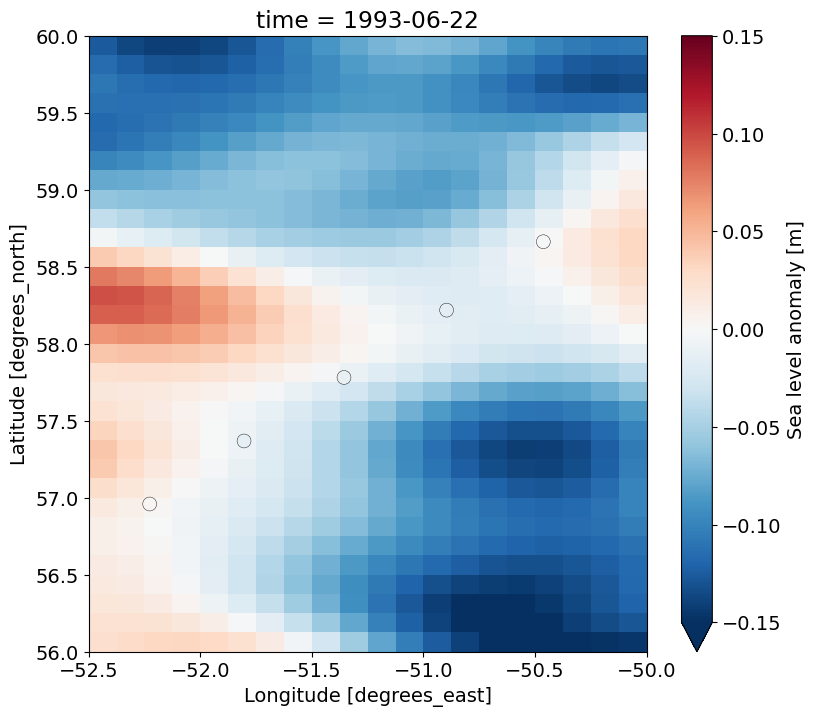

In [187]:
fig, ax = plt.subplots(figsize=(9, 8))

ssh_1993.sel(time='1993-06-22').sla.plot(ax=ax,vmin=-0.15,vmax=0.15,cmap='RdBu_r')

# Plot points for 1993
sc = ax.scatter(sla_ctd.longitude.values,sla_ctd.latitude.values,
    c=sla_ctd.values,s=100,
    cmap='RdBu_r',vmin=-0.15,vmax=0.15,
    marker='o',edgecolors='k',linewidths=0.3)

ax.set_xlim(-52.5,-50)
ax.set_ylim(56,60)